In [49]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
#import mpl_toolkits.basemap as bm

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline
N = 23 # put your index here
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[N % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm


Populating the interactive namespace from numpy and matplotlib
Реализуем алгоритм кластеризации 'DBSCAN. (параметры - epsilon, min_pts)'


<type 'numpy.ndarray'> (100, 4) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


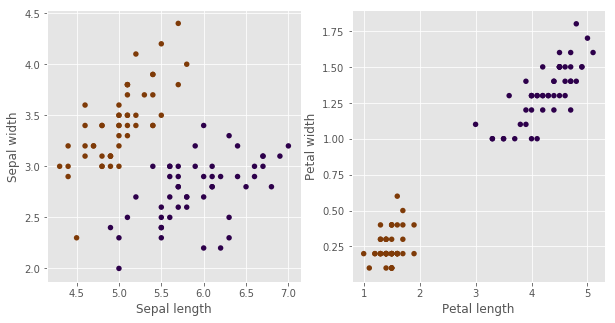

In [160]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

print type(x_iris), x_iris.shape , y_iris

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()


def dist(x,y):
    sum=0
    for i in xrange(x.shape[1]):
        sum+=(x[0][i]-y[0][i])**2
        print x[0][i], y[0][i], sum, i
    sum=sum**(float(1)/2)
    return sum

In [196]:
#Реализация алгоритма DBSCAN
from sklearn.base import BaseEstimator, ClusterMixin

class DBSCAN(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """
    
    def __init__(self, min_pts = 5, eps = 1.6):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        self.min_pts = min_pts
        self.eps = eps
        
    def fit(self, x ):
        """
        Use data matrix x to compute model parameters
        """
        self.flags = np.zeros(x.shape[0])
        self.x_len = len(x)
        attendance = np.zeros(x.shape[0])
        k=2
        for i in xrange(x.shape[0]):
            if attendance[i]==0:
                attendance[i] = 1 # mark as visited
                self.flags[i]=k
            else:
                continue
            nbr_ = self.neighbours(i, x, attendance, k) # set of neighbours
            if nbr_.shape[1] < self.min_pts:
                self.flags[i] = 1    # mark noise 
                self.flags[nbr_]=0
                attendance[nbr_]=0    #возвращаем непосещаемость точкам
                 
            else: 
                self.expand_cluster(nbr_, x, attendance, k)
                k+=1
        clusters = set([])
        for i in xrange(x.shape[0]):
            if self.flags[i] not in clusters:
                clusters.add(self.flags[i])
        self.K=len(clusters)
        return self.flags
    
    def neighbours(self, i, x, attendance, k):
        nbr = np.array([[]], dtype = int)
        for j in xrange(x.shape[0]):
            if attendance[j]==0:
                d = cdist(x[i].reshape(1,-1), x[j].reshape(1,-1), metric = 'euclidean')
                if d<self.eps:
                    attendance[j]=1   # mark visited
                    nbr_add = np.array([[0]], dtype = int)
                    nbr_add[0][0] = j
                    nbr = np.concatenate((nbr, nbr_add), axis=1)
                    self.flags[j]=k
        return nbr
    
    def expand_cluster(self, nbr, NV, attendance, k):
        for i in xrange(nbr.shape[0]):
            #print "Вызвали внутри expand_cluster"
            nbr_new = self.neighbours(nbr[0][i], NV, attendance, k)
            if (nbr_new.shape[1] >= self.min_pts):
                self.expand_cluster (nbr_new, NV, attendance, k)
            else:
                self.flags[nbr_new]=0
                attendance[nbr_new]=0
    
    def predict(self, x):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        return self.flags
    
    def fit_predict(self, x):
        self.fit(x)
        return self.predict(x)
    
    
    def quality(self,x, y):
        """
        Implement quality criterion of your choice
        """
        K=1
        clusters = set([])
        max = 0
        for i in xrange(x.shape[0]):
            if y[i] not in clusters:
                clusters.add(y[i])
                if y[i]>max:
                    max = y[i]
        min = max
        K=len(clusters)
        for i in xrange(x.shape[0]):
            if y[i]<min:
                min = y[i]
        for i in xrange(x.shape[0]):
            y[i]-=(min-1)
        self.K = K
        if K==1:
            return 1
        a = np.zeros(x.shape[0], dtype = float)
        b = np.zeros((x.shape[0],int(K)-1), dtype = float)
        silhouette = 0
        for i in xrange(x.shape[0]):
            k=0
            for j in xrange(x.shape[0]):
                if y[j]==y[i]:
                    a[i] += cdist(x[i].reshape(1,-1), x[j].reshape(1,-1), metric = 'euclidean')
                    k+=1
            if k!=0:
                a[i]/=k
            else:
                print "y =", y
                print "Error"
                return -1
            for l in xrange(1,int(K)+1):
                if (l!=y[i]):
                    c=0
                    k=0
                    for j in xrange(x.shape[0]):
                        if y[j]==l:
                            b[i][c] = b[i][c] + cdist(x[i].reshape(1,-1), x[j].reshape(1,-1), metric = 'euclidean')
                            k+=1
                    if k!=0:
                        b[i][c]/=k
                    else:
                        print 'y =', y
                        print "Error"
                        return -1
                    c+=1
            min = b[i][0]
            c=0
            for l in xrange(1,int(K)):
                if min > b[i][c]:
                    min = b[i][c]
                    print min
                    c+=1
            if min>a[i]:
                b[i][0]= min
            else:
                b[i][0] = a[i]
            min = (min-a[i])/b[i][0]
            silhouette+=min
        silhouette/=x.shape[0]
        return silhouette

In [191]:
model = DBSCAN()
y_iris = model.fit(x_iris)
print np.where(y_iris==-1), y_iris

(array([], dtype=int64),) [ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  3.  3.  3.  3.
  3.  3.  3.  1.  3.  3.  1.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  1.  3.  3.  3.  3.  1.  3.]


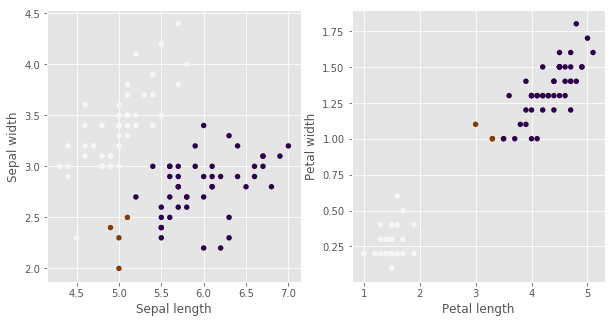

In [192]:
pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[15:,2], x_iris[15:, 3], c=y_iris[15:], cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

In [170]:
x_iris = iris.data[:100]
pred_iris = DBSCAN().fit_predict(x_iris)
print "pred_iris =",pred_iris, np.where(pred_iris==-1)
y_iris = iris.target[:100]
print "y_iris =", y_iris
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

pred_iris = [ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  3.  3.  3.  3.
  3.  3.  3.  1.  3.  3.  1.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  1.  3.  3.  3.  3.  1.  3.] (array([], dtype=int64),)
y_iris = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Adjusted Rand index for iris is: 0.93


Разница в точках, которые помечены как шум.

In [171]:
model.quality(x_iris, pred_iris)

0.77539437110145248

In [197]:
ks = range(1, 10)
ls = range(1,20)
criteria = np.zeros((len(ks),len(ls)))

class max_():
    def __init__(self, max=0, dim = 1):
        dim=np.zeros(dim)
        self.dim = dim
        self.max = max

        
max = max_(0,2) 

for i,k in enumerate(ks):
    for j,l in enumerate(ls):
        model = DBSCAN()
        model.min_pts = k
        model.eps = l*0.1
        y_iris = model.fit_predict(x_iris)
        criteria[i][j] = model.quality(x_iris, y_iris)
        if (max.max<criteria[i][j])*(model.K==3):
            max.max=criteria[i][j]
            max.dim[0] = model.min_pts
            max.dim[1] = model.eps
print "Highest coef of quality =",max.max, "min_pts and eps =",max.dim    

Highest coef of quality = 0.775394371101 min_pts and eps = [ 5.   1.6]


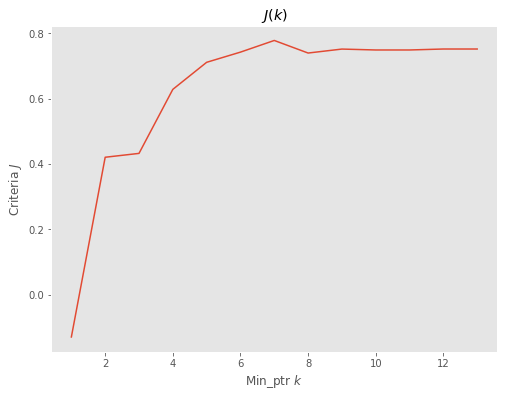

In [10]:
pl.figure(figsize=(8, 6))
pl.plot(ls, criteria[1])
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Min_ptr $k$")
pl.grid()
pl.show()

In [36]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]
for i in xrange(y_iris.shape[0]):
    y_iris[i]+=1
print y_iris
model = DBSCAN()
model.quality(x_iris,y_iris)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
K = 2


0.74219807974664487

In [12]:
df_sns = pd.read_csv('WDIData.csv', sep=',')
df_sns = df_sns.fillna(0)
df_sns.columns

Index([u'Country Name', u'Country Code', u'Indicator Name', u'Indicator Code',
       u'1960', u'1961', u'1962', u'1963', u'1964', u'1965', u'1966', u'1967',
       u'1968', u'1969', u'1970', u'1971', u'1972', u'1973', u'1974', u'1975',
       u'1976', u'1977', u'1978', u'1979', u'1980', u'1981', u'1982', u'1983',
       u'1984', u'1985', u'1986', u'1987', u'1988', u'1989', u'1990', u'1991',
       u'1992', u'1993', u'1994', u'1995', u'1996', u'1997', u'1998', u'1999',
       u'2000', u'2001', u'2002', u'2003', u'2004', u'2005', u'2006', u'2007',
       u'2008', u'2009', u'2010', u'2011', u'2012', u'2013', u'2014', u'2015',
       u'2016', u'Unnamed: 61'],
      dtype='object')

In [141]:
#Преобразование данных как указано в описании дз2
df = pd.DataFrame()

df.loc[:,'Country Name']= df_sns['Country Name']
df.loc[:,'Indicator Name'] = df_sns['Indicator Name']
df.loc[:,'2012'] = df_sns['2012']

df = df['2012'].groupby([df['Country Name'],df['Indicator Name']]).mean().unstack()
x=df.columns
for i in range(x.shape[0]):
    if df[x[i]].max()!=df[x[i]].min():
        df[x[i]] = (df[x[i]]-df[x[i]].mean())/(df[x[i]].max()-df[x[i]].min())
    else:
        df[x[i]]=0
print df

Indicator Name            2005 PPP conversion factor, GDP (LCU per international $)  \
Country Name                                                                          
Afghanistan                                                               0           
Albania                                                                   0           
Algeria                                                                   0           
American Samoa                                                            0           
Andorra                                                                   0           
Angola                                                                    0           
Antigua and Barbuda                                                       0           
Arab World                                                                0           
Argentina                                                                 0           
Armenia                                    

In [157]:
#запись данных в массив
data = np.zeros((264,1553))
print data.shape
data=df.iloc[:].values
print data

(264, 1553)
[[ 0.          0.         -0.08226281 ..., -0.01381462 -0.02843143
   0.04787738]
 [ 0.          0.         -0.08226281 ..., -0.01381462 -0.02843143
   0.06364797]
 [ 0.          0.          0.72494058 ..., -0.01381462 -0.02843143
   0.29611365]
 ..., 
 [ 0.          0.         -0.08226281 ..., -0.01381462  0.39489753
   0.20458034]
 [ 0.          0.         -0.08226281 ..., -0.01381462 -0.02843143
   0.47204227]
 [ 0.          0.         -0.08226281 ..., -0.01381462 -0.02843143
   0.49143609]]


Нахождение наилучших аргументов для метода кластеризации:

In [156]:
ks = range(1, 10)
ls = range(1,90)
criteria = np.zeros((len(ks),len(ls)))
max = max_(0,266)
for i,k in enumerate(ks):
    for j,l in enumerate(ls):
        model = DBSCAN()
        model.min_pts = k
        model.eps = l*0.1
        y_iris = model.fit(data)
        criteria[i][j] = model.quality(data, y_iris)
        if (max.max<criteria[i][j])*(criteria[i][j]!=1):
            max.max=criteria[i][j]
            max.dim[:264]=y_iris
            max.dim[264]=model.min_pts
            max.dim[265]=model.eps
        
print 'coef of quality =', max.max, 'min_pts =',max.dim[264], 'eps =', max.dim[265]

coef of quality = 0.667335887189 min_pts = 1.0 eps = 8.7


In [135]:
y = np.zeros(264)
model = DBSCAN()
model.min_pts = 1.0
model.eps = 8.7
y = model.fit(data)

print y , model.quality(data,y)

[ 2.  3.  3.  2.  2.  2.  2.  2.  4.  3.  2.  4.  4.  3.  2.  2.  2.  2.
  4.  3.  2.  2.  1.  3.  3.  3.  2.  3.  2.  2.  3.  2.  2.  3.  3.  2.
  2.  2.  2.  2.  3.  2.  2.  2.  5.  4.  2.  2.  2.  3.  2.  3.  3.  2.
  3.  3.  4.  2.  1.  3.  3.  5.  5.  5.  3.  3.  3.  2.  1.  3.  6.  4.
  4.  3.  5.  4.  2.  2.  4.  2.  4.  2.  2.  2.  1.  4.  3.  2.  3.  2.
  2.  2.  3.  3.  2.  2.  2.  2.  5.  3.  7.  3.  5.  5.  2.  1.  2.  4.
  2.  1.  1.  2.  4.  2.  4.  3.  2.  4.  2.  3.  2.  2.  2.  4.  2.  3.
  3.  1.  5.  3.  4.  3.  3.  2.  2.  2.  2.  2.  2.  3.  8.  2.  5.  4.
  7.  3.  6.  2.  4.  2.  2.  4.  2.  2.  3.  3.  2.  2.  2.  2.  8.  3.
  2.  1.  3.  2.  2.  2.  2.  2.  2.  4.  2.  2.  2.  3.  2.  4.  2.  4.
  2.  4.  2.  2.  2.  2.  2.  4.  2.  4.  3.  2.  3.  3.  5.  2.  2.  1.
  3.  5.  2.  2.  2.  2.  2.  2.  3.  2.  2.  1.  2.  3.  3.  2.  2.  2.
  4.  2.  2.  2.  3.  3.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  4.  4.
  2.  2.  2.  4.  2.  2.  2.  2.  3.  3.  2.  2.  2

Визуализация с помощью TCNE:

(264, 2)


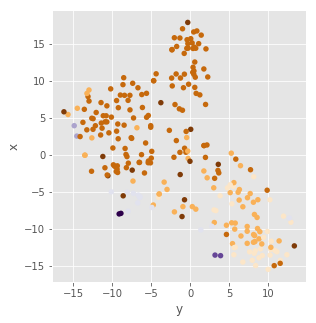

In [140]:
from sklearn.manifold import TSNE
data_embedded = TSNE(n_components=2).fit_transform(data)
print data_embedded.shape

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(data_embedded[:, 0], data_embedded[:, 1], c=y, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('y')
plt.ylabel('x')

pl.show()

Далее я показываю в каком кластере какие страны:

In [143]:
df.index[y==1]

Index([u'Bermuda', u'Dominica', u'Eritrea', u'Georgia', u'IDA only',
       u'Indonesia', u'Iran, Islamic Rep.', u'Lao PDR', u'Mongolia', u'Qatar',
       u'Singapore', u'Vietnam', u'West Bank and Gaza', u'World'],
      dtype='object', name=u'Country Name')

In [144]:
df.index[y==2]

Index([u'Afghanistan', u'American Samoa', u'Andorra', u'Angola',
       u'Antigua and Barbuda', u'Arab World', u'Aruba', u'Bahamas, The',
       u'Bahrain', u'Bangladesh',
       ...
       u'Turks and Caicos Islands', u'Tuvalu', u'Uganda', u'Uruguay',
       u'Uzbekistan', u'Vanuatu', u'Venezuela, RB', u'Virgin Islands (U.S.)',
       u'Yemen, Rep.', u'Zambia'],
      dtype='object', name=u'Country Name', length=139)

In [145]:
df.index[y==3]

Index([u'Albania', u'Algeria', u'Armenia', u'Azerbaijan', u'Belgium',
       u'Bhutan', u'Bolivia', u'Bosnia and Herzegovina', u'Brazil',
       u'Bulgaria', u'Cabo Verde', u'Cambodia',
       u'Central Europe and the Baltics', u'Costa Rica', u'Croatia', u'Cuba',
       u'Cyprus', u'Czech Republic', u'Dominican Republic',
       u'Early-demographic dividend', u'Ecuador', u'Egypt, Arab Rep.',
       u'El Salvador', u'Estonia',
       u'Europe & Central Asia (IDA & IBRD countries)', u'Ghana', u'Greece',
       u'Guatemala', u'Guinea', u'Honduras', u'Hungary', u'Italy',
       u'Kazakhstan', u'Kuwait', u'Kyrgyz Republic',
       u'Latin America & Caribbean',
       u'Latin America & the Caribbean (IDA & IBRD countries)', u'Latvia',
       u'Lithuania', u'Macedonia, FYR', u'Mauritius', u'Mexico', u'Moldova',
       u'Montenegro', u'Niger', u'Peru', u'Poland', u'Portugal', u'Romania',
       u'Serbia', u'Slovak Republic', u'Slovenia', u'Spain', u'Sri Lanka',
       u'Tunisia', u'Turkey', u'

In [147]:
df.index[y==4]

Index([u'Argentina', u'Australia', u'Austria', u'Belarus', u'Colombia',
       u'Denmark', u'Euro area', u'Europe & Central Asia', u'European Union',
       u'Finland', u'France', u'Germany', u'Iceland', u'Ireland', u'Israel',
       u'Japan', u'Korea, Rep.',
       u'Latin America & Caribbean (excluding high income)', u'Luxembourg',
       u'Malaysia', u'Malta', u'Netherlands', u'North America', u'Norway',
       u'OECD members', u'Panama', u'Paraguay', u'South Africa', u'Sweden',
       u'Switzerland', u'Thailand', u'Ukraine', u'United Kingdom',
       u'United States'],
      dtype='object', name=u'Country Name')

In [148]:
df.index[y==5]

Index([u'China', u'East Asia & Pacific',
       u'East Asia & Pacific (IDA & IBRD countries)',
       u'East Asia & Pacific (excluding high income)',
       u'Europe & Central Asia (excluding high income)', u'High income',
       u'IBRD only', u'IDA & IBRD total', u'Late-demographic dividend',
       u'Lower middle income', u'Post-demographic dividend',
       u'Russian Federation', u'Upper middle income'],
      dtype='object', name=u'Country Name')

In [149]:
df.index[y==6]

Index([u'Ethiopia', u'Madagascar'], dtype='object', name=u'Country Name')

In [150]:
df.index[y==7]

Index([u'Hong Kong SAR, China', u'Macao SAR, China'], dtype='object', name=u'Country Name')

In [152]:
df.index[y==8]

Index([u'Low & middle income', u'Middle income'], dtype='object', name=u'Country Name')